<a href="https://colab.research.google.com/github/MingSheng92/AE_denoise/blob/master/VAE_wip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/MingSheng92/AE_denoise.git

Cloning into 'AE_denoise'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 96 (delta 38), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%load /content/AE_denoise/scripts/utility.py
%load /content/AE_denoise/scripts/Variational_ae.py

from AE_denoise.scripts.utility import load_data, faceGrid, ResultGrid, subsample, AddNoiseToMatrix, noisy
from AE_denoise.scripts.Variational_ae import VAE

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
img_data, label, img_size = load_data('/content/drive/My Drive/FaceDataset/CroppedYaleB', 0)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(img_data.T, label, test_size=0.1, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=111)

print("Total number of training samples: ", x_train.shape)
print("Total number of training samples: ", x_val.shape)
print("Total number of validation samples: ", x_test.shape)

Total number of training samples:  (1962, 28224)
Total number of training samples:  (218, 28224)
Total number of validation samples:  (243, 28224)


In [0]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#x_train = x_train.reshape(-1, img_size[0], img_size[1], 1)
#x_val = x_val.reshape(-1, img_size[0], img_size[1], 1)
#x_train = np.reshape(x_train, (len(x_train), img_size[0], img_size[1], 1))
#x_val = np.reshape(x_val, (len(x_val), img_size[0], img_size[1], 1))
#x_test = np.reshape(x_test, (len(x_test), img_size[0], img_size[1], 1)) 

In [0]:
vae = VAE(28224, 512, 2)
vae.instantiate_VAE(loss='cross_entropy')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
vae.get_encoder("image")
vae.get_decoder("image")
vae.get_VAE("image")

In [0]:
#vae._fit(x_train, x_val)

vae.VAE_model.fit(x_train, x_train,
            epochs=50,
            batch_size=64,
            validation_data=(x_test, x_test))

ValueError: ignored

---------------------------------------------------

In [0]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = img_size[0]
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(20, 20))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

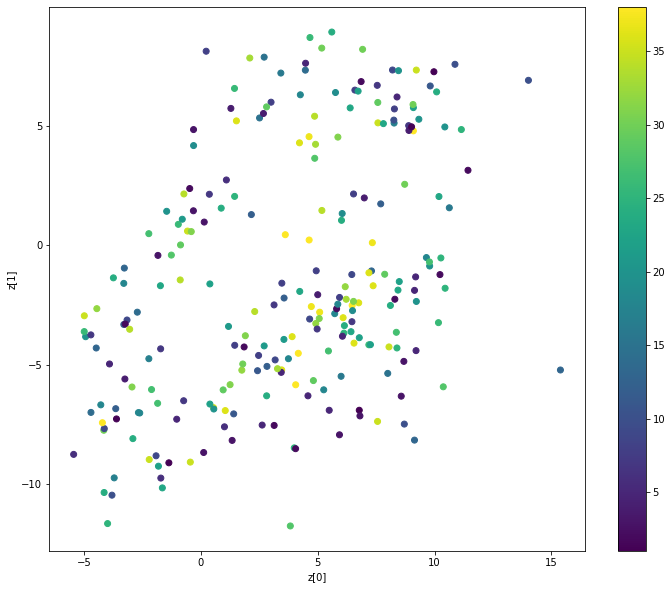

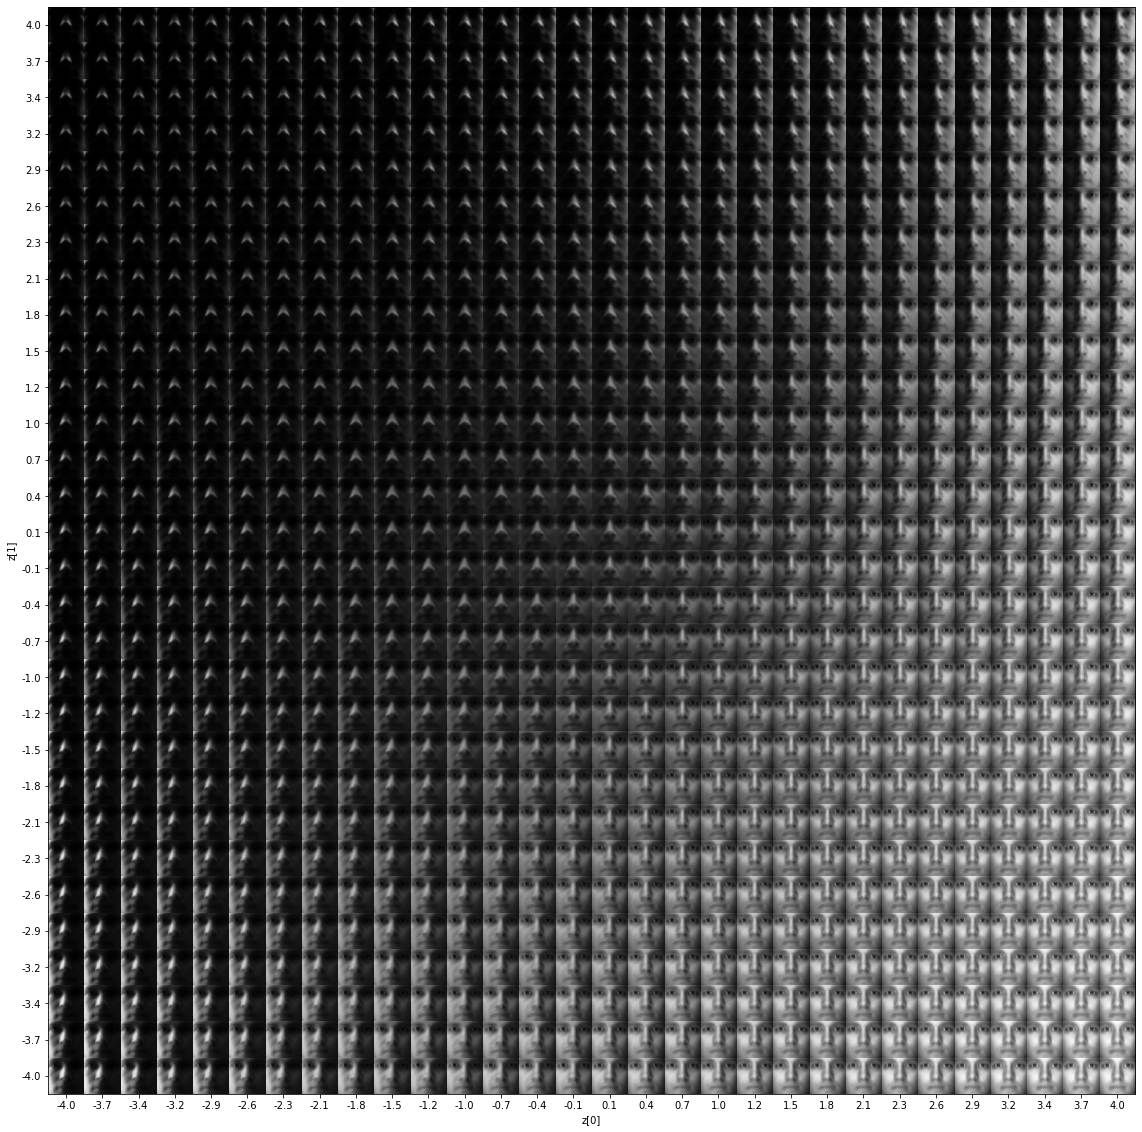

In [0]:
import os

models = (vae.encoder, vae.decoder)
data = (x_test, y_test)

plot_results(models,
    data,
    batch_size= vae.batch_size,
    model_name="vae_mlp")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 128
epochs = 100
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 194.7808 - val_loss: 174.3252
Epoch 2/100
48000/60000 [=======================>......] - ETA: 0s - loss: 171.5601

KeyboardInterrupt: ignored

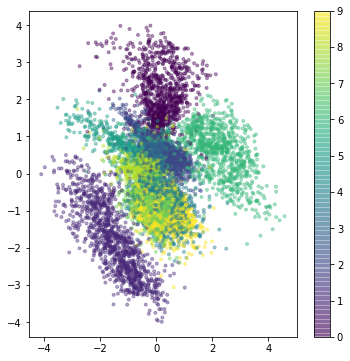

In [0]:
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

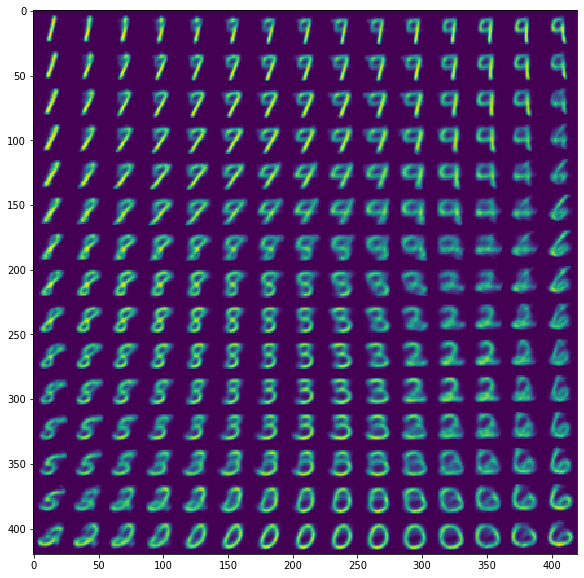

In [0]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))))
plt.show()

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import argparse
import matplotlib.pyplot as plt

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## VAE 
class test_VAE(object):
    # initialize class value for later processing purpose
    def __init__(self, original_dim, intermediate_dim, latent_dim, batch_size=128, epochs=50):
        self.original_dim = original_dim
        self.input_shape = (original_dim, )
        self.intermediate_dim = intermediate_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.encoder = None
        self.decoder = None
        self.VAE_model = None
    
    def instantiate_VAE(self, loss='mse'):
        # build encoder model
        inputs = Input(shape=self.input_shape, name='encoder_input')
        x = Dense(self.intermediate_dim, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(self.intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(self.original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        
        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        
        self.VAE_model = Model(inputs, outputs, name='vae_mlp')
        
        if loss == 'mse':
            reconstruction_loss = mse(inputs, outputs)
        elif loss == 'cross_entropy':
             reconstruction_loss = binary_crossentropy(inputs, outputs)
        else:
            raise ValueError('Loss selected not found...')
            
        reconstruction_loss *= self.original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.VAE_model.add_loss(vae_loss)
        self.VAE_model.compile(optimizer='adam')
    
    def _fit(self, x_train, x_test):
        # train the autoencoder
        self.VAE_model.fit(x_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_data=(x_test, None))
    
    def get_encoder(self, dsp_type):
        if dsp_type == "spec":
            self.encoder.summary()
        elif dsp_type == "image":
            plot_model(self.encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
        
    def get_decoder(self, dsp_type):
        if dsp_type == "spec":
            self.decoder.summary()
        elif dsp_type == "image":
            plot_model(self.decoder, to_file='vae_mlp_decoder.png', show_shapes=True)
            
    def get_VAE(self, dsp_type):
        if dsp_type == "spec":
            self.VAE_model.summary()
        elif dsp_type == "image":
            plot_model(self.VAE_model, to_file='vae.png', show_shapes=True)